In [1]:
import numpy as np
import random
import re
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class GridWorldModel:
    def __init__(self, grid_size=(4, 4)):
        self.grid_size = grid_size
        self.states = [(i, j, g_i, g_j) for i in range(grid_size[0]) for j in range(grid_size[1]) 
                       for g_i in range(grid_size[0]) for g_j in range(grid_size[1])]
        self.actions = ['N', 'S', 'E', 'W', 'X']  # Corresponding to north, south, east, west, hover
        self.observations = ['SW', 'NW', 'NE', 'SE', 'Det', 'None']  # Based on quadrant camera model from paper
        
        # Ground agent initial state (can be anywhere but not in the corners initially)
        non_corner_states = [(i, j) for i in range(self.grid_size[0]) for j in range(self.grid_size[1])
                             if (i, j) not in [(0, 0), (0, self.grid_size[1] - 1), (self.grid_size[0] - 1, 0), (self.grid_size[0] - 1, self.grid_size[1] - 1)]]
        self.ground_agent_state = random.choice(non_corner_states)
        
        # Transition matrix: T[s, s', a] - Probability of transitioning from state s to s' given action a
        self.T = np.zeros((len(self.states), len(self.states), len(self.actions)))
        
        # Defining transition probabilities
        for idx, state in enumerate(self.states):
            drone_pos = (state[0], state[1])
            agent_pos = (state[2], state[3])
            for action_idx, action in enumerate(self.actions):
                # Get next drone position based on action
                next_drone_pos = self._get_next_position(drone_pos, action)
                # Get possible next positions for the ground agent
                possible_agent_moves = self._get_possible_agent_moves(agent_pos)
                # Distribute probability across all possible next agent positions
                for next_agent_pos in possible_agent_moves:
                    next_state = (next_drone_pos[0], next_drone_pos[1], next_agent_pos[0], next_agent_pos[1])
                    next_state_idx = self.states.index(next_state)
                    self.T[idx, next_state_idx, action_idx] = 1.0 / len(possible_agent_moves)
        
        # Observation matrix: O[s, o, a] - Probability of observing o given state s and action a
        self.O = np.zeros((len(self.states), len(self.observations), len(self.actions)))
        
        # Defining observation probabilities based on limited camera FOV model
        for idx, state in enumerate(self.states):
            drone_pos = (state[0], state[1])
            ground_pos = (state[2], state[3])
            for action_idx in range(len(self.actions)):
                if drone_pos == ground_pos:
                    # Ground agent is directly under the drone
                    self.O[idx, self.observations.index('SW'), action_idx] = 0.25
                    self.O[idx, self.observations.index('NW'), action_idx] = 0.25
                    self.O[idx, self.observations.index('NE'), action_idx] = 0.25
                    self.O[idx, self.observations.index('SE'), action_idx] = 0.25
                else:
                    # Determining the relative position of the ground agent to the drone within limited FOV (only adjacent positions)
                    i_diff = ground_pos[0] - drone_pos[0]
                    j_diff = ground_pos[1] - drone_pos[1]
                    if i_diff == -1 and j_diff == 0:
                        # Ground agent is directly south
                        self.O[idx, self.observations.index('SW'), action_idx] = 0.5
                        self.O[idx, self.observations.index('SE'), action_idx] = 0.5
                    elif i_diff == 1 and j_diff == 0:
                        # Ground agent is directly north
                        self.O[idx, self.observations.index('NW'), action_idx] = 0.5
                        self.O[idx, self.observations.index('NE'), action_idx] = 0.5
                    elif i_diff == 0 and j_diff == 1:
                        # Ground agent is directly east
                        self.O[idx, self.observations.index('NE'), action_idx] = 0.5
                        self.O[idx, self.observations.index('SE'), action_idx] = 0.5
                    elif i_diff == 0 and j_diff == -1:
                        # Ground agent is directly west
                        self.O[idx, self.observations.index('NW'), action_idx] = 0.5
                        self.O[idx, self.observations.index('SW'), action_idx] = 0.5
                    elif i_diff == -1 and j_diff == -1:
                        # Ground agent is in the south-west diagonal
                        self.O[idx, self.observations.index('SW'), action_idx] = 1.0
                    elif i_diff == -1 and j_diff == 1:
                        # Ground agent is in the south-east diagonal
                        self.O[idx, self.observations.index('SE'), action_idx] = 1.0
                    elif i_diff == 1 and j_diff == -1:
                        # Ground agent is in the north-west diagonal
                        self.O[idx, self.observations.index('NW'), action_idx] = 1.0
                    elif i_diff == 1 and j_diff == 1:
                        # Ground agent is in the north-east diagonal
                        self.O[idx, self.observations.index('NE'), action_idx] = 1.0
                    else:
                        # If the ground agent is not within the limited FOV (not adjacent)
                        self.O[idx, self.observations.index('None'), action_idx] = 1.0
        self.R = np.zeros((len(self.states), len(self.actions)))
        
        # Defining rewards
        goal_state = (4, 4)  # Defining the goal state for drone
        for idx, state in enumerate(self.states):
            drone_pos = (state[0], state[1])
            for action_idx, action in enumerate(self.actions):
                if drone_pos == goal_state:
                    self.R[idx, action_idx] = 100  # Reward for reaching the goal
                else:
                    self.R[idx, action_idx] = -1  # Penalty for each step to encourage shorter paths

    def get_next_state(self, state, action):
        drone_pos = (state[0], state[1])
        ground_pos = (state[2], state[3])
        
        # Get next drone position based on action
        next_drone_pos = self._get_next_position(drone_pos, action)
        
        # Get next ground agent position
        next_ground_pos = self.ground_agent_next_state(ground_pos)
        
        return (next_drone_pos[0], next_drone_pos[1], next_ground_pos[0], next_ground_pos[1])

    def _get_next_position(self, position, action):
        i, j = position
        if action == 'N':
            return (min(i + 1, self.grid_size[0] - 1), j)  # Moving north increases row number
        elif action == 'S':
            return (max(i - 1, 0), j)  # Moving south decreases row number
        elif action == 'E':
            return (i, min(j + 1, self.grid_size[1] - 1))  # Moving east increases column number
        elif action == 'W':
            return (i, max(j - 1, 0))  # Moving west decreases column number
        elif action == 'X':
            return (i, j)
        return position

    def _get_possible_agent_moves(self, agent_pos):
        """Get all possible next positions for the ground agent."""
        i, j = agent_pos
        possible_moves = []

        # Define possible moves for the ground agent
        if i > 0:  # Can move south
            possible_moves.append((i - 1, j))
        if i < self.grid_size[0] - 1:  # Can move north
            possible_moves.append((i + 1, j))
        if j > 0:  # Can move west
            possible_moves.append((i, j - 1))
        if j < self.grid_size[1] - 1:  # Can move east
            possible_moves.append((i, j + 1))

        # Add staying in place
        possible_moves.append((i, j))

        return possible_moves

    def get_next_state(self, state, action):
        drone_pos = (state[0], state[1])
        ground_pos = (state[2], state[3])
        
        # Get next drone position based on action
        next_drone_pos = self._get_next_position(drone_pos, action)
        
        # Get next ground agent position
        next_ground_pos = self.ground_agent_next_state(ground_pos)
        
        return (next_drone_pos[0], next_drone_pos[1], next_ground_pos[0], next_ground_pos[1])

    def _get_next_position(self, position, action):
        i, j = position
        if action == 'N':
            return (min(i + 1, self.grid_size[0] - 1), j)  # Moving north increases row number
        elif action == 'S':
            return (max(i - 1, 0), j)  # Moving south decreases row number
        elif action == 'E':
            return (i, min(j + 1, self.grid_size[1] - 1))  # Moving east increases column number
        elif action == 'W':
            return (i, max(j - 1, 0))  # Moving west decreases column number
        elif action == 'X':
            return (i, j)
        return position

    def ground_agent_next_state(self, ground_state):
        # Ground agent moves randomly to any adjacent state or stays in the same state, avoiding corners
        i, j = ground_state
        possible_moves = []
        
        # Define possible moves
        if i > 0:  # Can move south
            possible_moves.append((i - 1, j))
        if i < self.grid_size[0] - 1:  # Can move north
            possible_moves.append((i + 1, j))
        if j > 0:  # Can move west
            possible_moves.append((i, j - 1))
        if j < self.grid_size[1] - 1:  # Can move east
            possible_moves.append((i, j + 1))
        
        # Add staying in place if not in a corner
        if (i, j) not in [(0, 0), (0, self.grid_size[1] - 1), (self.grid_size[0] - 1, 0), (self.grid_size[0] - 1, self.grid_size[1] - 1)]:
            possible_moves.append((i, j))
        
        # Choose next position uniformly from possible moves
        next_position = random.choice(possible_moves)
        return next_position

    def get_transition_prob(self, state, action):
        action_idx = self.actions.index(action)
        state_idx = self.states.index(state)
        return self.T[state_idx, :, action_idx]

    def get_observation_prob(self, state, action):
        action_idx = self.actions.index(action)
        state_idx = self.states.index(state)
        return self.O[state_idx, :, action_idx]

    def get_reward(self, state, action):
        state_idx = self.states.index(state)
        action_idx = self.actions.index(action)
        return self.R[state_idx, action_idx]

    def get_next_state_and_observation(self, state, action):
        # Get the next state and observation probability distribution
        next_state_idx = np.argmax(self.get_transition_prob(state, action))
        next_state = self.states[next_state_idx]
        observation_prob = self.get_observation_prob(state, action)
        return next_state, observation_prob
    
    def plot_belief(self, belief):
        """
        Plot a 5x5 heatmap representing the belief about the agent's location.
        
        Args:
            belief (array): The belief vector over all states.
        """
        belief_grid = np.zeros((self.grid_size[0], self.grid_size[1]))
        for idx, state in enumerate(self.states):
            ground_pos = (state[2], state[3])
            # Adjust to set the origin at the lower left corner
            belief_grid[ground_pos[0], ground_pos[1]] += belief[idx]
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(belief_grid, annot=True, cmap='viridis', cbar=True, square=True, linewidths=.5)
        plt.title("Belief Distribution Over Ground Agent's Location")
        plt.xlabel("Column (0 is on the left)")
        plt.ylabel("Row (0 is at the bottom)")
        plt.gca().invert_yaxis()

    def plot_belief(self, belief):
        """
        Plot a 5x5 heatmap representing the belief about the agent's location.
        
        Args:
            belief (array): The belief vector over all states.
        """
        belief_grid = np.zeros((self.grid_size[0], self.grid_size[1]))
        for idx, state in enumerate(self.states):
            ground_pos = (state[2], state[3])
            # Adjust to set the origin at the lower left corner
            belief_grid[ground_pos[0], ground_pos[1]] += belief[idx]
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(belief_grid, annot=True, cmap='viridis', cbar=True, square=True, linewidths=.5)
        plt.title("Belief Distribution Over Ground Agent's Location")
        plt.xlabel("Column (0 is on the left)")
        plt.ylabel("Row (0 is at the bottom)")
        plt.gca().invert_yaxis()
        plt.show()

    def plot_drone_state(self, belief):
        """
        Plot a 5x5 heatmap representing the belief about the drone's location.
        
        Args:
            belief (array): The belief vector over all states.
        """
        drone_belief_grid = np.zeros((self.grid_size[0], self.grid_size[1]))
        for idx, state in enumerate(self.states):
            drone_pos = (state[0], state[1])
            # Adjust to set the origin at the lower left corner
            drone_belief_grid[drone_pos[0], drone_pos[1]] += belief[idx]
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(drone_belief_grid, annot=True, cmap='viridis', cbar=True, square=True, linewidths=.5)
        plt.title("Belief Distribution Over Drone's Location")
        plt.xlabel("Column (0 is on the left)")
        plt.ylabel("Row (0 is at the bottom)")
        plt.gca().invert_yaxis()
        plt.show()
    
    def calculate_risk(self, belief):
        """
        Find the most likely position of the drone and calculate the risk of collision.

        Args:
            belief (array): The belief vector over all states.

        Returns:
            tuple: (risk), where:
                - risk: Probability of the ground agent being in the same block or adjacent to the drone.
        """
        # Initialize the belief grid for the drone
        drone_belief_grid = np.zeros(self.grid_size)
        
        # Populate the belief grid for the drone's position
        for idx, state in enumerate(self.states):
            drone_pos = (state[0], state[1])  # Extract drone position (row, col)
            drone_belief_grid[drone_pos[0], drone_pos[1]] += belief[idx]
        
        # Find the most likely position of the drone
        max_belief_idx = np.unravel_index(np.argmax(drone_belief_grid), drone_belief_grid.shape)
        drone_row, drone_col = max_belief_idx

        # Calculate the risk (sum of probabilities where the agent is adjacent to or at the same block as the drone)
        risk = 0.0
        for idx, state in enumerate(self.states):
            agent_row, agent_col = state[2:4]  # Extract agent position (row, col)

            # Check adjacency or same block: Manhattan distance <= 1
            if abs(agent_row - drone_row) + abs(agent_col - drone_col) <= 1:
                risk += belief[idx]
        
        return risk
        
    def plot_drone_and_agent_state(self, state):
            """
            Plot a 5x5 heatmap representing the drone's and the agent's current state.
            If the drone and the agent are at the same position, use different colors to represent both.
            
            Args:
                state (tuple): The current state represented as (drone_x, drone_y, agent_x, agent_y).
            """
            belief_grid = np.zeros((self.grid_size[0], self.grid_size[1], 3))  # 3 channels for RGB
            drone_pos = (state[0], state[1])
            agent_pos = (state[2], state[3])

            # Adjust to set the origin at the lower left corner
            drone_idx = (drone_pos[0], drone_pos[1])
            agent_idx = (agent_pos[0], agent_pos[1])
            # drone_idx = (self.grid_size[0] - 1 - drone_pos[0], drone_pos[1])
            # agent_idx = (self.grid_size[0] - 1 - agent_pos[0], agent_pos[1])

            # Set colors: red for drone, blue for agent, magenta if they overlap
            if drone_idx == agent_idx:
                belief_grid[drone_idx] = [1.0, 0.0, 1.0]  # Magenta for overlap
            else:
                belief_grid[drone_idx] = [1.0, 0.0, 0.0]  # Red for drone
                belief_grid[agent_idx] = [0.0, 0.0, 1.0]  # Blue for agent

            plt.figure(figsize=(8, 6))
            plt.imshow(belief_grid, interpolation='nearest')
            plt.title("Drone and Ground Agent's Location")
            plt.xlabel("Column (0 is on the left)")
            plt.ylabel("Row (0 is at the bottom)")
            plt.gca().invert_yaxis()
            plt.show()


In [3]:
class DFA:
    def __init__(self, mona_dfa_string):
        self.states = set()
        self.transitions = {}
        self.accepting_states = set()
        self.rejecting_states = set()
        self.initial_state = None
        self.parse_mona_dfa(mona_dfa_string)
        self.identify_rejecting_states()

    def parse_mona_dfa(self, mona_dfa_string):
        lines = mona_dfa_string.splitlines()
        
        for line in lines:
            if 'shape = doublecircle' in line:
                self.accepting_states = set(map(int, re.findall(r'\d+', line)))
            elif 'init ->' in line:
                self.initial_state = int(re.search(r'init -> (\d+)', line).group(1))
            elif '->' in line:
                match = re.match(r'(\d+) -> (\d+) \[label="(.+?)"\]', line)
                if match:
                    from_state, to_state, label = int(match.group(1)), int(match.group(2)), match.group(3)
                    if from_state not in self.transitions:
                        self.transitions[from_state] = []
                    self.transitions[from_state].append((to_state, label))

                    # Add the states to the state set
                    self.states.add(from_state)
                    self.states.add(to_state)

    def identify_rejecting_states(self):
        for state in self.states:
            if (state in self.transitions and len(self.transitions[state]) == 1 and
                    self.transitions[state][0][0] == state and self.transitions[state][0][1] == 'true' and
                    state not in self.accepting_states):
                self.rejecting_states.add(state)

    def transition(self, current_state, context):
        """
        Returns the next DFA state based on the current state and context (a dictionary with values for `a` and `b`).
        """
        for (next_state, label) in self.transitions.get(current_state, []):
            if self.evaluate_condition(label, context):
                return next_state
        return current_state  # If no condition matches, remain in current state

    def evaluate_condition(self, label, context):
        """
        Evaluates the logical condition in `label` using the `context` dictionary, where context = {'a': bool, 'b': bool}.
        """
        # Translate logical operators
        condition = label.replace("~", "not ").replace("&", "and").replace("|", "or")
        
        try:
            # Safely evaluate the expression using the context
            return eval(condition, {}, context)
        except Exception as e:
            print(f"Error evaluating condition {label}: {e}")
            return False
    def get_dfa_reward(self, dfa_state):
        return 1 if dfa_state in self.accepting_states else 0





In [4]:
class MCTSNode:
    def __init__(self, belief, model, dfa_state, parent=None):
        self.belief = belief  # Belief state
        self.model = model  # Model instance
        self.dfa_state = dfa_state  # DFA state
        self.parent = parent  # Parent node
        self.q_value = np.zeros(len(self.model.actions))  # Q-values for each action
        self.visits = np.zeros(len(self.model.actions))  # Visit counts for each action
        self.total_visits = 0  # Total number of times this node has been visited
        self.children = {}    # Child nodes

    def is_fully_expanded(self):
        return len(self.children) == len(self.model.actions) * len(dfa.states) 

    def best_child(self, c_param=2):
        choices_weights = []
        for action in range(len(self.model.actions)):
            if self.visits[action] == 0:
                weight = float('inf')
            else:
                weight = self.q_value[action] + c_param * math.sqrt(math.log(self.total_visits) / (self.visits[action]))
            choices_weights.append(weight)
        max_val = np.max(choices_weights)
        max_indices = np.where(choices_weights == max_val)[0]
        chosen_index = random.choice(max_indices)
        return chosen_index

def update_pomdp_dfa(belief, dfa_state, action, observation, model, dfa):
    """Update the POMDP belief and DFA state based on the action and observation."""
    # Update belief based on the action taken and observation
    belief, _ = transition_belief(belief, action, observation, model)

    
    dfa_reward = dfa.get_dfa_reward(dfa_state)
    # Update DFA state
    # context = {'a': belief[0] < 0.01, 'b': belief[0] < 0.01}
    # context = iLTL_atomic_proposition(belief)
    if dfa_state in dfa.accepting_states or  dfa_state in dfa.rejecting_states:
        dfa_state = dfa_state
    else:
        dfa_state = dfa.transition(dfa_state, iLTL_atomic_proposition(belief, model))
    
    return belief, dfa_state, dfa_reward


def transition_belief(belief, action, observation, model):
    """
    Update the belief state based on the action taken and observation using matrix operations.
    """
    # Use matrix multiplication to update the belief
    action_idx = model.actions.index(action)
    transition_matrix = model.T[:, :, action_idx]  # Get the transition matrix for the given action
    new_belief = np.dot(belief, transition_matrix)

    # Update belief based on the observation model using the observation matrix
    observation_idx = model.observations.index(observation)
    observation_matrix = model.O[:, observation_idx, action_idx]  # Extract the observation probabilities

    # Update belief with the extracted observation probabilities
    new_belief *= observation_matrix

    # Normalize the belief
    normalizing_factor = np.sum(new_belief)
    if normalizing_factor > 0:
        new_belief /= normalizing_factor

    return new_belief, observation

def search(root, model, timeout=20000):
    dfa_state = root.dfa_state
    for _ in range(timeout):
        root.dfa_state = dfa_state
        sampled_state = random.choices(model.states, weights=root.belief)[0]
        simulate(root, sampled_state, model, depth=0, max_depth=20)
    return root.best_child(c_param=0)

def rollout(node, belief, state, model, depth, max_depth):
    # here belief is not node.belief
    # rollout should return the return of the path starting on the node for certain steps
    # the blief is updated but node is fixed
    if depth >= max_depth or node.dfa_state in dfa.rejecting_states:
        return 0
    if node.dfa_state in dfa.accepting_states:
        return 1
    action = random.choice(model.actions)
    # Execute the action and get an observation
    state = random.choices(model.states, weights=model.get_transition_prob(state, action))[0]
    observation = random.choices(model.observations, weights=model.get_observation_prob(state, action))[0]
    belief, node.dfa_state, dfa_reward = update_pomdp_dfa(belief, node.dfa_state, action, observation, model, dfa)
    
    # return dfa_reward
    # # Recursively continue the rollout
    next_rollout = rollout(node, belief, state, model, depth + 1, max_depth)
    return 0.9*next_rollout

def simulate(node, true_state, model, depth, max_depth):

    if depth >= max_depth:
        return 0
    if not node.is_fully_expanded():
        # node.total_visits += 1
        expand(node, model)
        return rollout(node, node.belief, true_state, model, depth, max_depth)

    action = node.best_child()
    state = random.choices(model.states, weights=model.get_transition_prob(true_state, model.actions[action]))[0]
    observation = random.choices(model.observations, weights=model.get_observation_prob(state , model.actions[action]))[0]
    belief, new_dfa_state, dfa_reward = update_pomdp_dfa(node.belief, node.dfa_state, model.actions[action], observation, model, dfa)
    if new_dfa_state in dfa.accepting_states:
        result = 1
    elif new_dfa_state in dfa.rejecting_states:
        result = 0
    else:      
        child_key = (model.actions[action], new_dfa_state)
        result = simulate(node.children[child_key], true_state, model, depth + 1, max_depth)
        
    node.total_visits += 1
    node.visits[action] += 1
    node.q_value[action] += (result - node.q_value[action]) / node.visits[action]

    return result

def select(node, model):
    while node.is_fully_expanded():
        action = node.best_child()
        node = node.children[model.actions[action]]
    return node

def expand(node, model):
    if node.dfa_state in dfa.accepting_states or node.dfa_state in dfa.rejecting_states:
        return node  # Do not expand further if the node is in an accepting or rejecting state
    
    for action_idx, action in enumerate(model.actions):
        for next_dfa_state in dfa.states:
            child_key = (action, next_dfa_state)
            if child_key not in node.children:
                # Determine the next belief state and DFA state based on the action
                # context = {'a': node.belief[0] < 0.01, 'b': node.belief[0] < 0.01}
                new_dfa_state = dfa.transition(node.dfa_state, iLTL_atomic_proposition(node.belief, model))
                belief, _, dfa_reward = update_pomdp_dfa(node.belief, node.dfa_state, action, 'None', model, dfa)
                new_child = MCTSNode(belief, model=model, dfa_state=new_dfa_state, parent=node)
                node.children[child_key] = new_child
    return node  # Do not expand further if the node is in an accepting or rejecting state

In [5]:
model = GridWorldModel()
# Example DFA string input
mona_dfa_string = """
digraph MONA_DFA {
rankdir = LR;
center = true;
size = "7.5,10.5";
edge [fontname = Courier];
node [height = .5, width = .5];
node [shape = doublecircle]; 4;
node [shape = circle]; 1;
init [shape = plaintext, label = ""];
init -> 1;
1 -> 1 [label="~a & ~b"];
1 -> 2 [label="b & ~a"];
1 -> 3 [label="a & ~b"];
1 -> 4 [label="a & b"];
2 -> 2 [label="true"];
3 -> 3 [label="~b"];
3 -> 4 [label="b"];
4 -> 4 [label="true"];
}
"""

dfa = DFA(mona_dfa_string)

def iLTL_atomic_proposition(belief, model):
    """Determine the iLTL atomic proposition based on the belief."""
    # return {'a': belief[0] < 0.01, 'b': belief[0] < 0.01}
    goal_position = (3, 3)
    goal_state_indices = [idx for idx, state in enumerate(model.states) if (state[0], state[1]) == goal_position]

    
    # risk = model.calculate_risk(belief)
    return {'a': belief.max()>0.9 , 'b': belief[goal_state_indices].sum()>0}
    return {'a': True, 'b': belief[goal_state_indices].sum()>0}
    return {'a': risk < 0.7, 'b': belief[goal_state_indices].sum()>0}

# def iLTL_atomic_proposition(belief, model):
#     """Determine the iLTL atomic proposition based on the belief."""
#     # return {'a': belief[0] < 0.01, 'b': belief[0] < 0.01}
#     goal_position = (3, 3)
#     goal_state_indices = [idx for idx, state in enumerate(model.states) if (state[0], state[1]) == goal_position]
#     return {'a': True, 'b': belief[goal_state_indices].sum()>0}

initial_belief = np.zeros(len(model.states))
for idx, state in enumerate(model.states):
    drone_pos = (state[0], state[1])
    ground_pos = (state[2], state[3])
    # Set initial belief for states where the drone is at (0, 0) and the ground agent is not in a corner
    if drone_pos == (0,0) and ground_pos not in [(0, 0), (0, model.grid_size[1] - 1), (model.grid_size[0] - 1, 0), (model.grid_size[0] - 1, model.grid_size[1] - 1)]:
        initial_belief[idx] = 1
# Normalize the initial belief
initial_belief /= np.sum(initial_belief)
for idx, state in enumerate(model.states):
    drone_pos = (state[0], state[1])
    ground_pos = (state[2], state[3])
    # Set initial belief to 0 for corner positions of the ground agent
    if ground_pos in [(0, 0), (0, model.grid_size[1] - 1), (model.grid_size[0] - 1, 0), (model.grid_size[0] - 1, model.grid_size[1] - 1)]:
        initial_belief[idx] = 0
# Normalize the initial belief
initial_belief /= np.sum(initial_belief)
initial_state = model.states[np.random.choice(len(model.states), p=initial_belief)]


belief = initial_belief
dfa_state=dfa.initial_state
state = initial_state


steps_hist = []
belief_max_hist = []


In [6]:
experiment_results = []  # To store results for all experiments
num_experiments = 100  # Total number of experiments
max_steps = 100      # Maximum steps per experiment

for experiment_id in tqdm(range(num_experiments)):
    model = GridWorldModel()
    dfa = DFA(mona_dfa_string)
    initial_belief = np.zeros(len(model.states))
    for idx, state in enumerate(model.states):
        drone_pos = (state[0], state[1])
        ground_pos = (state[2], state[3])
        # Set initial belief for states where the drone is at (0, 0) and the ground agent is not in a corner
        if drone_pos == (0,0) and ground_pos not in [(0, 0), (0, model.grid_size[1] - 1), (model.grid_size[0] - 1, 0), (model.grid_size[0] - 1, model.grid_size[1] - 1)]:
            initial_belief[idx] = 1
    # Normalize the initial belief
    initial_belief /= np.sum(initial_belief)
    for idx, state in enumerate(model.states):
        drone_pos = (state[0], state[1])
        ground_pos = (state[2], state[3])
        # Set initial belief to 0 for corner positions of the ground agent
        if ground_pos in [(0, 0), (0, model.grid_size[1] - 1), (model.grid_size[0] - 1, 0), (model.grid_size[0] - 1, model.grid_size[1] - 1)]:
            initial_belief[idx] = 0
    # Normalize the initial belief
    initial_belief /= np.sum(initial_belief)
    initial_state = model.states[np.random.choice(len(model.states), p=initial_belief)]

    belief = initial_belief
    dfa_state=dfa.initial_state
    state = initial_state

    state_hist = []
    action_hist = []
    observation_hist = []
    belief_hist = []
    belief_max_hist = []
    steps_hist = []

    steps = 0
    confidence = 0
    belief_flag = True

    while dfa_state not in [4, 2] and steps < max_steps:
        state_hist.append(state) 
        belief_hist.append(belief)
        
        if  belief_flag:
            belief_max_hist.append(belief.max())
            if belief.max() > 0.9:
                belief_flag = False
                
        # belief_max_hist.append(belief.max())

        # model.plot_belief(belief)
        # print(belief.max())

        # model.plot_drone_and_agent_state(state)

        root = MCTSNode(belief, model, dfa_state)
        best_action_index = search(root, model, timeout=2000)
        # print(model.actions[best_action_index])
        action = model.actions[best_action_index]
        state = model.get_next_state(state, action)
        observation = random.choices(model.observations, weights=model.get_observation_prob(state, action))[0]
        # print(observation)
        
        dfa_state = dfa.transition(dfa_state, iLTL_atomic_proposition(belief, model))
        #next_state and next_belief
        belief = transition_belief(belief, model.actions[best_action_index], observation, model)[0]
        # print(root.q_value)

        observation_hist.append(observation)
        action_hist.append(action)
        steps = steps+1

    success = dfa_state == 4
    # Save results for this experiment
    experiment_results.append({
        "experiment_id": experiment_id + 1,
        "steps": steps,
        "success": success,  # Record success status
        "belief_max_hist": belief_max_hist,  # Record the full belief max history
    })

100%|██████████| 100/100 [2:58:31<00:00, 107.11s/it] 


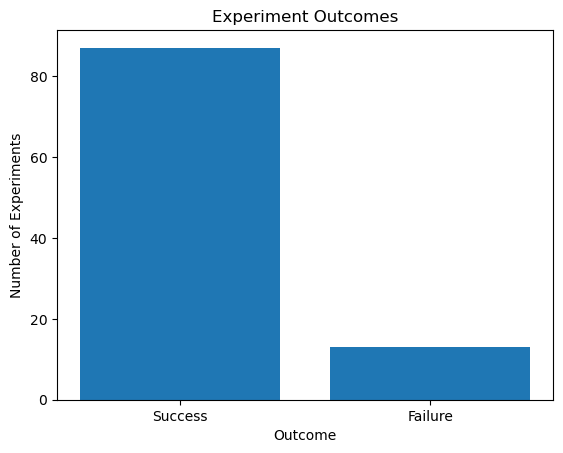

In [7]:
# Count successes and failures
num_success = sum(result["success"] for result in experiment_results)
num_failures = len(experiment_results) - num_success

# Data for the bar chart
labels = ["Success", "Failure"]
counts = [num_success, num_failures]

# Plot the bar chart
plt.bar(labels, counts)
plt.title("Experiment Outcomes")
plt.xlabel("Outcome")
plt.ylabel("Number of Experiments")
plt.show()

In [13]:
counts

[87, 13]

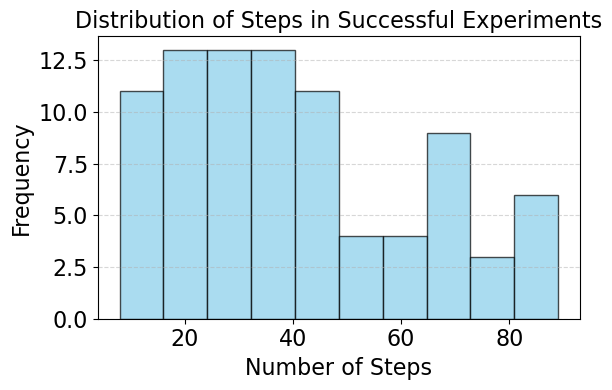

In [15]:
# Data: Filter successful experiments
steps_data_success = [result["steps"] for result in experiment_results if result["success"]]

# Plot the histogram
fig, ax = plt.subplots(figsize=(6, 4))  # Adjust size for professional presentation
bins = 10  # Define number of bins

ax.hist(steps_data_success, bins=bins, edgecolor="black", color="skyblue", alpha=0.7)

# Title and axis labels
ax.set_title("Distribution of Steps in Successful Experiments", fontsize=16)
ax.set_xlabel("Number of Steps", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16)

# Customize tick parameters for a clean look
ax.tick_params(axis="both", which="major", labelsize=16)
ax.grid(axis="y", linestyle="--", alpha=0.5)  # Add a grid only for the y-axis

# Tight layout for saving the figure
fig.tight_layout()

# Save the plot with high resolution for the paper
plt.savefig("steps_distribution_successful_experiments.png", dpi=300, bbox_inches="tight")
plt.show()

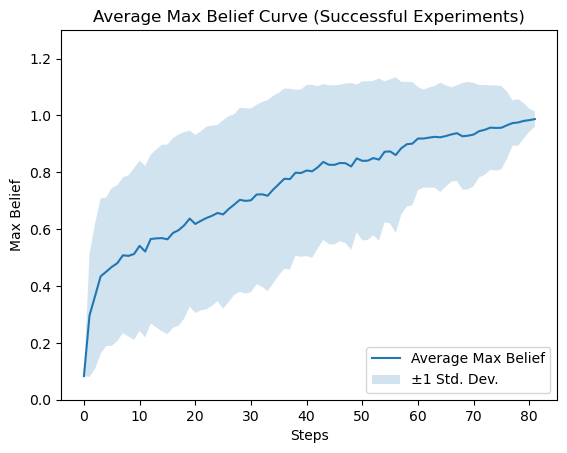

In [9]:
def extend_belief_max_histories(experiment_results, target_length, success_only=False):
    """
    Extend all belief_max_hist lists to the same length by filling with the last value.
    
    Args:
        experiment_results (list): List of experiment result dictionaries.
        target_length (int): Target length to extend all belief_max_hist to.
        success_only (bool): Whether to include only successful experiments.
        
    Returns:
        np.array: Array of belief_max_hist, all of the same length.
    """
    if success_only:
        experiments = [result for result in experiment_results if result["success"]]
    else:
        experiments = experiment_results

    extended_beliefs = []
    for result in experiments:
        belief_max_hist = result["belief_max_hist"]
        # Extend with the last value to reach the target length
        extended = belief_max_hist + [belief_max_hist[-1]] * (target_length - len(belief_max_hist))
        extended_beliefs.append(extended[:target_length])  # Ensure it doesn't exceed the target length
    
    return np.array(extended_beliefs)

# Set the target length (e.g., maximum length of any belief_max_hist)
target_length = max(len(result["belief_max_hist"]) for result in experiment_results if result["success"])

# Extend belief_max_hist for successful experiments
extended_beliefs = extend_belief_max_histories(experiment_results, target_length, success_only=True)

# Compute the average and standard deviation
mean_beliefs = np.mean(extended_beliefs, axis=0)
std_beliefs = np.std(extended_beliefs, axis=0)

# Plot the average belief_max_hist curve
x = range(target_length)  # x-axis is the step index
plt.plot(x, mean_beliefs, label="Average Max Belief")
plt.fill_between(x, mean_beliefs - std_beliefs, mean_beliefs + std_beliefs, alpha=0.2, label="±1 Std. Dev.")
plt.title("Average Max Belief Curve (Successful Experiments)")
plt.xlabel("Steps")
plt.ylabel("Max Belief")
plt.ylim(0, 1.3)
plt.legend(loc="lower right")
plt.show()

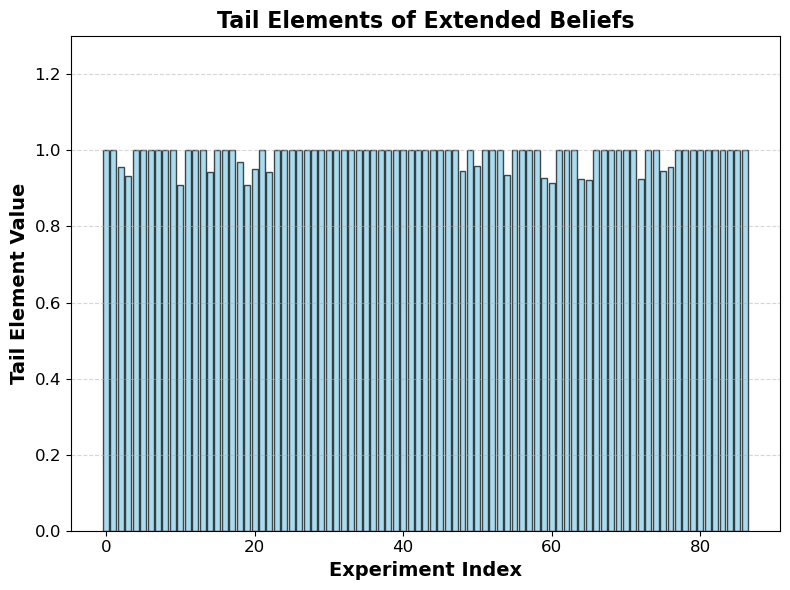

In [18]:
def plot_tail_elements(extended_beliefs):
    """
    Plot the tail elements of extended belief_max_hist arrays.
    
    Args:
        extended_beliefs (np.array): Array of extended belief_max_hist lists.
    """
    tail_elements = extended_beliefs[:, -1]  # Get the last element of each array
    
    # Plot the tail elements as a bar chart
    plt.figure(figsize=(8, 6))
    plt.bar(range(len(tail_elements)), tail_elements, color="skyblue", edgecolor="black", alpha=0.7)
    plt.title("Tail Elements of Extended Beliefs", fontsize=16, weight="bold")
    plt.xlabel("Experiment Index", fontsize=14, weight="bold")
    plt.ylabel("Tail Element Value", fontsize=14, weight="bold")
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(0, 1.3)  # Assuming the values are between 0 and 1
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

# Example usage
extended_beliefs = extend_belief_max_histories(experiment_results, target_length=100, success_only=True)
plot_tail_elements(extended_beliefs)

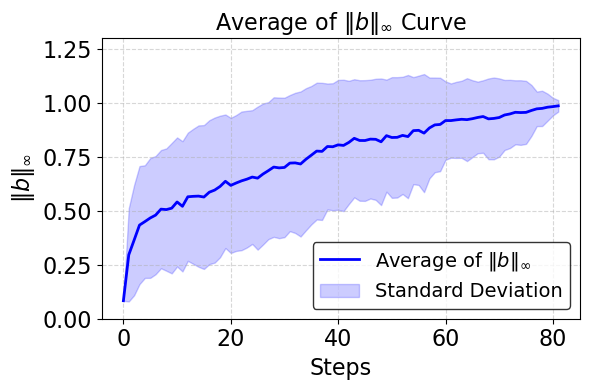

In [14]:
fig, ax = plt.subplots(figsize=(6, 4))  # Adjust the size for better visibility in papers
x = range(target_length)  # x-axis is the step index

# Plot the main curve
ax.plot(x, mean_beliefs, label=r"Average of $\Vert b \Vert_\infty$", linewidth=2, color="blue")

# Add shaded area for ±1 Standard Deviation
ax.fill_between(
    x, 
    mean_beliefs - std_beliefs, 
    mean_beliefs + std_beliefs, 
    color="blue", 
    alpha=0.2, 
    label=r"Standard Deviation"
)

# Set axis labels with LaTeX
ax.set_title(r"Average of $\Vert b \Vert_\infty$ Curve", fontsize=16)
ax.set_xlabel("Steps", fontsize=16)
ax.set_ylabel(r"$\Vert b \Vert_\infty$", fontsize=16)

# Set y-axis range
ax.set_ylim(0, 1.3)

# Format the legend
ax.legend(
    loc="lower right",
    fontsize=14,
    frameon=True, 
    fancybox=True, 
    framealpha=0.8, 
    edgecolor="black"
)

# Customize tick parameters for professional look
ax.tick_params(axis="both", which="major", labelsize=16)
ax.grid(True, linestyle="--", alpha=0.5)  # Add grid lines for better readability

# Tight layout for saving the figure
fig.tight_layout()

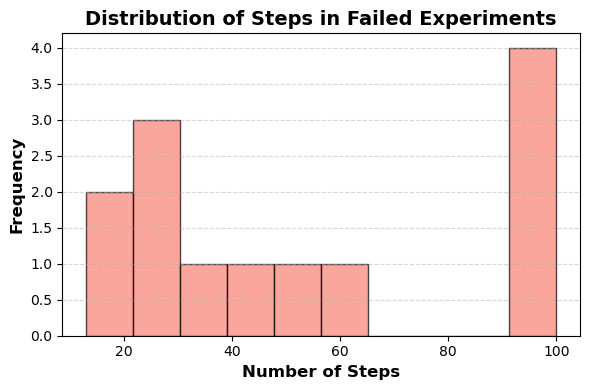

In [12]:
# Filter steps data for failed experiments
steps_data_fail = [result["steps"] for result in experiment_results if not result["success"]]

# Plot the histogram
fig, ax = plt.subplots(figsize=(6, 4))  # Adjust size for professional presentation
bins = 10  # Define number of bins

ax.hist(steps_data_fail, bins=bins, edgecolor="black", color="salmon", alpha=0.7)

# Title and axis labels
ax.set_title("Distribution of Steps in Failed Experiments", fontsize=14, weight="bold")
ax.set_xlabel("Number of Steps", fontsize=12, weight="bold")
ax.set_ylabel("Frequency", fontsize=12, weight="bold")

# Customize tick parameters for a clean look
ax.tick_params(axis="both", which="major", labelsize=10)
ax.grid(axis="y", linestyle="--", alpha=0.5)  # Add a grid only for the y-axis

# Tight layout for saving the figure
fig.tight_layout()

# Save the plot with high resolution for the paper
plt.savefig("steps_distribution_failed_experiments.png", dpi=300, bbox_inches="tight")
plt.show()

In [19]:
def calculate_average_steps(experiment_results, success_only=False):
    """
    Calculate the average number of steps from experiment results.

    Args:
        experiment_results (list): List of experiment result dictionaries.
        success_only (bool): Whether to include only successful experiments.

    Returns:
        float: The average number of steps.
    """
    if success_only:
        steps = [result["steps"] for result in experiment_results if result["success"]]
    else:
        steps = [result["steps"] for result in experiment_results]
    
    return np.mean(steps)

# Example usage
average_steps_all = calculate_average_steps(experiment_results)
average_steps_success = calculate_average_steps(experiment_results, success_only=True)

print(f"Average Steps (All Experiments): {average_steps_all:.2f}")
print(f"Average Steps (Successful Experiments): {average_steps_success:.2f}")

Average Steps (All Experiments): 42.44
Average Steps (Successful Experiments): 40.71
